# Training Conditional GANs Using Poutyne

This example shows how to use the Poutyne's strategy interface in order to deeply modify the training process internal to Poutyne.
The main goal of Poutyne is to be very simple, yet flexible, to use.
It does so by providing sane but customizable defaults.
The aim of the strategy interface is to provide a lot of this flexibility in modifying the way Poutyne trains and evaluates your neural network.

This example was adapted from the [Keras documentation](https://keras.io/examples/generative/conditional_gan/). The TensorFlow code was "translated" into PyTorch code.

In [1]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets.mnist import MNIST
import imageio.v3 as iio

from poutyne import BaseStrategy, StepOutput, CumulativeAverage, Model

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [4]:
train_split_percent = 0.8

In [5]:
full_train_dataset = MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./datasets', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
train_length = int(math.floor(train_split_percent * num_data))
valid_length = num_data - train_length

train_dataset, valid_dataset = random_split(
    full_train_dataset, [train_length, valid_length], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [6]:
real_images, labels = next(iter(train_loader))

In [7]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

In [8]:
discriminator = nn.Sequential(
    nn.Conv2d(discriminator_in_channels, 64, 3, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.Conv2d(64, 128, 3, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(),
    nn.Linear(128, 1),
)

generator = nn.Sequential(
    nn.Linear(generator_in_channels, generator_in_channels * 7 * 7),
    nn.Unflatten(1, (generator_in_channels, 7, 7)),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(generator_in_channels, 128, 4, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.Conv2d(128, 1, 7, padding=3),
    nn.Sigmoid(),
)

network = nn.ModuleDict(dict(discriminator=discriminator, generator=generator))

In [9]:
network

ModuleDict(
  (discriminator): Sequential(
    (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AdaptiveMaxPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (generator): Sequential(
    (0): Linear(in_features=138, out_features=6762, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(138, 7, 7))
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(138, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (8): Sigmoid()
  )
)

In [10]:
class GANStrategy(BaseStrategy):
    def __init__(self, latent_dim, num_classes):
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.batch_metrics_average = CumulativeAverage()

    def get_batch_metric_names(self):
        return ['g_loss', 'd_loss']

    def compute_batch_metrics(self):
        return self.batch_metrics_average.compute()

    def reset_batch_metrics(self):
        self.batch_metrics_average.reset()

    def train_step(self, data, **kwargs):
        return self._step(data, training=True, **kwargs)

    def test_step(self, data, **kwargs):
        # Implementing this method allows us to have a validation steps when
        # training and enable us to call the evaluate* methods.
        return self._step(data, training=False, **kwargs)

    def _step(self, data, *, training=True, **kwargs):
        # Unpack the data.
        real_images, image_labels = data
        discriminator = self.model.network.discriminator
        generator = self.model.network.generator
        discriminator_optimizer, generator_optimizer = self.model.optimizers
        device = real_images.device

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        one_hot_labels = F.one_hot(image_labels, num_classes=self.num_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.expand(-1, -1, *real_images.shape[-2:])

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = real_images.shape[0]
        random_latent_vectors = torch.randn((batch_size, self.latent_dim), device=device)
        random_vector_labels = torch.cat((random_latent_vectors, one_hot_labels), axis=1)

        # Decode the noise (guided by labels) to fake images.
        generated_images = generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = torch.cat((generated_images, image_one_hot_labels), axis=1)
        real_image_and_labels = torch.cat((real_images, image_one_hot_labels), axis=1)
        combined_images = torch.cat((fake_image_and_labels, real_image_and_labels), axis=0)

        # Assemble labels discriminating real from fake images.
        labels = torch.cat(
            (torch.ones((batch_size, 1), device=device), torch.zeros((batch_size, 1), device=device)), axis=0
        )
        predictions = discriminator(combined_images)

        d_loss = self.model.loss_function(predictions, labels)
        if training:
            discriminator_optimizer.zero_grad()
            generator.zero_grad()
            d_loss.backward()
            discriminator_optimizer.step()

        # Sample random points in the latent space.
        random_latent_vectors = torch.randn((batch_size, self.latent_dim), device=device)
        random_vector_labels = torch.cat((random_latent_vectors, one_hot_labels), axis=1)

        # Assemble labels that say "all real images".
        misleading_labels = torch.zeros((batch_size, 1), device=device)

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        fake_images = generator(random_vector_labels)
        fake_image_and_labels = torch.cat((fake_images, image_one_hot_labels), axis=1)
        predictions = discriminator(fake_image_and_labels)

        g_loss = self.model.loss_function(predictions, misleading_labels)
        if training:
            discriminator.zero_grad()
            generator_optimizer.zero_grad()
            g_loss.backward()
            generator_optimizer.step()

        batch_metrics = [g_loss, d_loss]
        self.batch_metrics_average.update(batch_metrics, batch_size)

        return StepOutput(batch_metrics=batch_metrics, x=data)

In [11]:
strategy = GANStrategy(latent_dim, num_classes)

In [12]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0003)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0003)
model = Model(
    network, [discriminator_optimizer, generator_optimizer], 'bce_with_logits', strategy=strategy, device='cuda'
)

In [13]:
_ = model.fit_generator(train_loader, valid_loader, epochs=20)

Epoch:  1/20 Train steps: 750 Val steps: 188 24.42s g_loss: 0.893050 d_loss: 0.607388 val_g_loss: 0.699719 val_d_loss: 0.755248
Epoch:  2/20 Train steps: 750 Val steps: 188 24.31s g_loss: 0.951307 d_loss: 0.592437 val_g_loss: 0.919600 val_d_loss: 0.660756
Epoch:  3/20 Train steps: 750 Val steps: 188 24.39s g_loss: 2.940783 d_loss: 0.272113 val_g_loss: 1.395723 val_d_loss: 0.457293
Epoch:  4/20 Train steps: 750 Val steps: 188 24.57s g_loss: 2.251616 d_loss: 0.255573 val_g_loss: 2.170500 val_d_loss: 0.310764
Epoch:  5/20 Train steps: 750 Val steps: 188 24.58s g_loss: 2.967502 d_loss: 0.156768 val_g_loss: 3.251724 val_d_loss: 0.115795
Epoch:  6/20 Train steps: 750 Val steps: 188 24.63s g_loss: 3.778930 d_loss: 0.084587 val_g_loss: 3.897270 val_d_loss: 0.062823
Epoch:  7/20 Train steps: 750 Val steps: 188 24.61s g_loss: 4.505677 d_loss: 0.049980 val_g_loss: 4.477675 val_d_loss: 0.044684
Epoch:  8/20 Train steps: 750 Val steps: 188 24.69s g_loss: 4.991932 d_loss: 0.039344 val_g_loss: 5.0092

In [14]:
_ = model.evaluate_generator(test_loader, return_dict_format=True)

Test steps: 157 2.28s test_g_loss: 1.018641 test_d_loss: 0.603591                                                  


{'time': 2.278034443035722,
 'test_g_loss': 1.0186405668258667,
 'test_d_loss': 0.6035914352416992}

In [26]:
generator_model = Model(generator, None, None, device='cuda')

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = torch.randn((1, latent_dim))
interpolation_noise = interpolation_noise.expand(num_interpolation, latent_dim)


def interpolate_class(first_number, second_number):
    first_label = F.one_hot(torch.tensor([first_number]), num_classes=num_classes).float()
    second_label = F.one_hot(torch.tensor([second_number]), num_classes=num_classes).float()

    # Calculate the interpolation vector between the two labels.
    percent_second_label = torch.linspace(0, 1, num_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = torch.cat((interpolation_noise, interpolation_labels), axis=1)
    fake = generator_model.predict(noise_and_labels, convert_to_numpy=False).cpu()

    return fake


def get_gif(fake_images):
    converted_images = 255.0 * fake_images
    converted_images = F.interpolate(converted_images, (96, 96)).byte()
    converted_images = converted_images.expand(-1, 3, -1, -1)
    converted_images = torch.movedim(converted_images, 1, 3)
    converted_images = converted_images.numpy()
    return converted_images


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 5  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

Prediction steps: 1 0.02s                                          


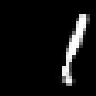

In [27]:
gif_data = iio.imwrite("<bytes>", get_gif(fake_images), format_hint=".gif", duration=100)
from IPython.display import Image

display(Image(data=gif_data, format='gif'))